In [172]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings("ignore")
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## 2a)

In [173]:
def elemental_stiffness_matrix(consts, h):
    alpha, b, c = consts
    return np.array([[alpha/h + b/2 + h*c/3, -alpha/h + b/2 + h*c/6],
                    [-alpha/h - b/2 + h*c/6, alpha/h - b/2 + h*c/3]])

def elemental_load_1(func, x1, x2, consts):
    h = x2 - x1
    f = np.zeros(2)
    f[0] = integrate.quad(lambda x: func(x, consts) * (x2 - x) / h, x1, x2)[0]
    f[1] = integrate.quad(lambda x: func(x, consts) * (x - x1) / h, x1, x2)[0]
    return f

In [174]:
def solve_system(Xk, func, consts, elemental_load = elemental_load_1):
    Mi = len(Xk)
    H = Xk[1:]-Xk[:-1]               # Element sizes
    Mk = Mi-1                        # Number of elements

    A = np.zeros((Mi,Mi))
    f = np.zeros((Mi))

    for k in range(0,Mk):
        Ak = elemental_stiffness_matrix(consts, H[k])
        fk = elemental_load(func, Xk[k], Xk[k+1], consts)
        A[k:k+2, k:k+2] += Ak
        f[k:k+2] += fk
    
    # Impose boundary condition
    # Dirichlet boundary conditions
    A[0,:] = 0;
    A[0,0] = 1
    f[0] = 0
    A[-1,:] = 0
    A[-1,-1] = 1
    f[-1] = 0

    U = np.linalg.solve(A,f)
    return U

In [206]:
def func_1(x, consts):
    alpha, b, c = consts
    return 2 * alpha + b * (1 - 2*x) + c * (x - x**2)

def func_2(x, consts):
    alpha, b, c = consts
    return 9 * np.pi**2 * alpha * np.sin(3*np.pi*x) + 3 * np.pi * b * np.cos(3*np.pi*x) + c* np.sin(3*np.pi * x)

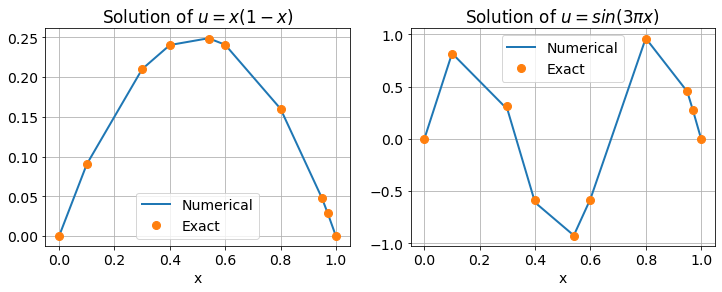

In [214]:
Xk = np.array([0, 0.1, 0.3, 0.4, 0.54, 0.6, 0.8, 0.95, 0.97, 1])
consts = [1,1,1]

U_1 = solve_system(Xk, func_1, consts)
U_2 = solve_system(Xk, func_2, consts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.set_title(r'Solution of $u=x(1-x)$')
ax1.plot(Xk, U_1, Xk, Xk * (1-Xk), 'o')
ax1.legend(['Numerical','Exact'])
ax1.set_xlabel('x');

ax2.set_title(r'Solution of $u=sin(3\pi x)$')
ax2.plot(Xk, U_2, Xk, np.sin(3*np.pi*Xk), 'o')
ax2.legend(['Numerical','Exact'])
ax2.set_xlabel('x')

plt.show()

## 2b)

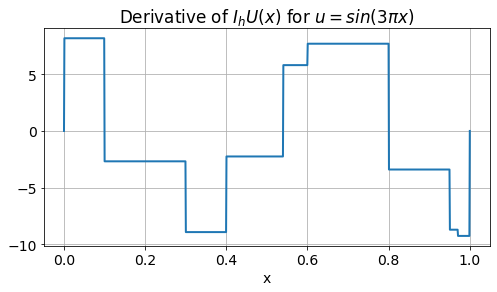

In [218]:
def uh_deriv(x, Xk, U):
    conds = []
    funs = []
    for i in range(len(Xk)- 1):
        conds.append((x > Xk[i]) * (x < Xk[i+1]))
        funs.append((U[i+1] - U[i]) / (Xk[i+1] - Xk[i]))
    return np.piecewise(x, conds, funs)

Xk = np.array([0, 0.1, 0.3, 0.4, 0.54, 0.6, 0.8, 0.95, 0.97, 1])
U = solve_system(Xk, func_2, [1,1,1])

x = np.linspace(0,1,1000)

plt.title(r'Derivative of $I_hU(x)$ for $u=sin(3\pi x)$')
plt.plot(x, uh_deriv(x, Xk, U))
plt.xlabel('x')
plt.show()

In [180]:
def l2_norm(u):
    u_squared = lambda x: u(x)**2
    norm,error = np.sqrt(integrate.quad(u_squared, 0, 1))
    #print("Estimated integration error: ", error)
    return norm

In [194]:
def convergence(start, num_points, func, u_exact, u_exact_deriv, consts, elemental_load = elemental_load_1):
    l2_errors = np.zeros(num_points)
    h1_errors = np.zeros(num_points)
    
    Mis = 2**(start + np.arange(num_points))
    hs = 1 / Mis
    for i in range(num_points):
        Xk = np.linspace(0, 1, Mis[i])
        U = solve_system(Xk, func, consts, elemental_load)

        l2_errors[i] = l2_norm(lambda x: u_exact(x) - np.interp(x, Xk, U))
        h1_errors[i] = np.sqrt(l2_errors[i]**2 + l2_norm(lambda x: u_exact_deriv(x) - uh_deriv(x, Xk, U))**2)
        
    return l2_errors, h1_errors, hs

In [195]:
def u_exact_1(x):
    return x * (1 - x)

def u_exact_1_deriv(x):
    return 1 - 2 * x

def u_exact_2(x):
    return np.sin(3 * np.pi * x)

def u_exact_2_deriv(x):
    return 3 * np.pi * np.cos(3 * np.pi * x)

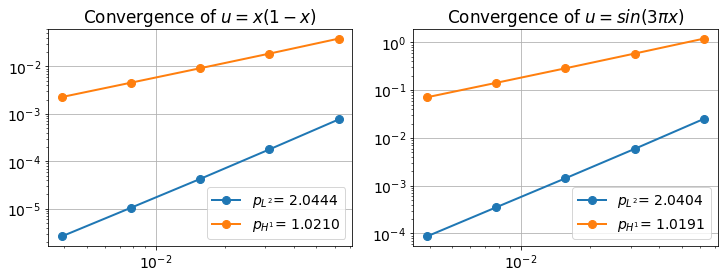

In [204]:
consts = [1, 1, 1]
l2_1, h1_1, hs_1 = convergence(4, 5, func_1, u_exact_1, u_exact_1_deriv, consts)
l2_2, h1_2, hs_2 = convergence(4, 5, func_2, u_exact_2, u_exact_2_deriv, consts)

order_l2_1 = np.polyfit(np.log(hs_1),np.log(l2_1), 1)[0]
order_h1_1 = np.polyfit(np.log(hs_1),np.log(h1_1), 1)[0]
order_l2_2 = np.polyfit(np.log(hs_2),np.log(l2_2), 1)[0]
order_h1_2 = np.polyfit(np.log(hs_2),np.log(h1_2), 1)[0]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.set_title(r'Convergence of $u=x(1-x)$')
ax1.loglog(hs_1, l2_1, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2_1))
ax1.loglog(hs_1, h1_1, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1_1))
ax1.legend()

ax2.set_title(r'Convergence of $u=sin(3\pi x)$')
ax2.loglog(hs_2, l2_2, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2_2))
ax2.loglog(hs_2, h1_2, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1_2))
ax2.legend()
plt.show()

## 2d)

In [185]:
def w_1(x):
    return np.piecewise(x, [x<=0.5, x>=0.5], [lambda x: 2*x, lambda x: 2*(1 - x)])

def wx_1(x):
    return np.piecewise(x, [x<=0.5, x>=0.5], [lambda x: 2, lambda x: -2])

def w_2(x):
    return x - np.abs(x)**(2/3)

def wx_2(x):
    return 1 - (2/3) * x**(-1/3)

In [186]:
def elemental_load_with_deriv(w, wx, x1, x2, consts):
    alpha, b, c = consts
    h = x2 - x1
    f = np.zeros(2)
    f[0] = alpha * wx(x1) + integrate.quad(lambda x: -alpha * wx(x) / h + (x2 - x) / h * (b * wx(x) + c * w(x)), x1, x2)[0]
    f[1] = -alpha * wx(x2) + integrate.quad(lambda x: alpha * wx(x) / h + (x - x1) / h * (b * wx(x) + c * w(x)) , x1, x2)[0]
    return f

In [198]:
Xk = np.array([0, 0.1, 0.3, 0.4, 0.5, 0.54, 0.6, 0.8, 0.95, 0.97, 1])

consts = [1, 1, 1]

def elemental_load_2(w, x1, x2, consts):
    return elemental_load_with_deriv(w, wx_1, x1, x2, consts)

def elemental_load_3(w, x1, x2, consts):
    return elemental_load_with_deriv(w, wx_2, x1, x2, consts)

# Solving systems
U_1 = solve_system(Xk, w_1, consts, elemental_load_2)
U_2 = solve_system(Xk, w_2, consts, elemental_load_3)

# Convergence rates
l2_1, h1_1, hs_1 = convergence(3, 5, w_1, w_1, wx_1, consts, elemental_load_2)
order_l2_1 = np.polyfit(np.log(hs_1),np.log(l2_1), 1)[0]
order_h1_1 = np.polyfit(np.log(hs_1),np.log(h1_1), 1)[0]

l2_2, h1_2, hs_2 = convergence(3, 5, w_2, w_2, wx_2, consts, elemental_load_3)
order_l2_2 = np.polyfit(np.log(hs),np.log(l2_2), 1)[0]
order_h1_2 = np.polyfit(np.log(hs),np.log(h1_2), 1)[0]

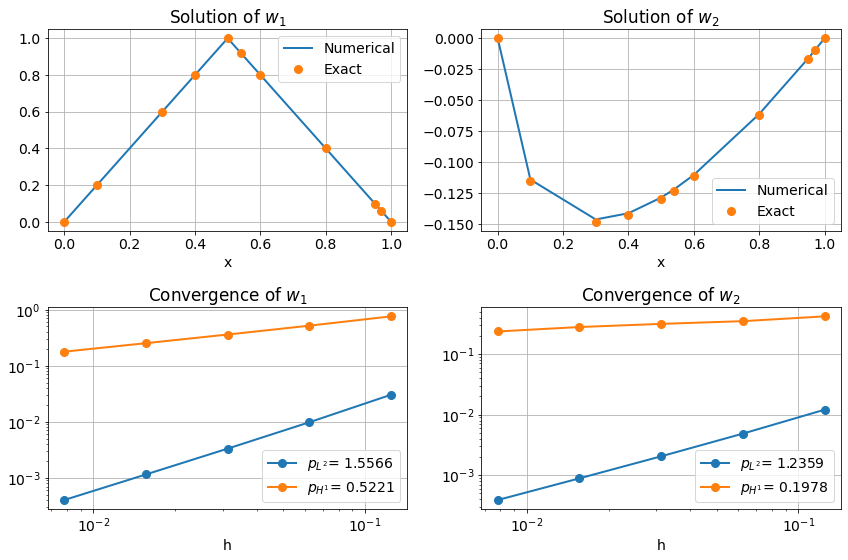

In [199]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))

ax1.set_title(r'Solution of $w_1$')
ax1.plot(Xk, U_1, Xk, w_1(Xk), 'o')
ax1.legend(['Numerical','Exact'])
ax1.set_xlabel('x');

ax2.set_title(r'Solution of $w_2$')
ax2.plot(Xk, U_2, Xk, w_2(Xk), 'o')
ax2.legend(['Numerical','Exact'])
ax2.set_xlabel('x');

ax3.set_title(r'Convergence of $w_1$')
ax3.loglog(hs_1, l2_1, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2_1))
ax3.loglog(hs_1, h1_1, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1_1))
ax3.set_xlabel('h');
ax3.legend()

ax4.set_title(r'Convergence of $w_2$')
ax4.loglog(hs_2, l2_2, '-o', label = r'$p_{L^{2}}$' + '= {:.4f}'.format(order_l2_2))
ax4.loglog(hs_2, h1_2, '-o', label = r'$p_{H^{1}}$' + '= {:.4f}'.format(order_h1_2))
ax4.set_xlabel('h');
ax4.legend()
fig.tight_layout()
plt.show()

## 2e)

In [189]:
def func_4(x, consts):
    return x**(-1/4)

In [190]:
Xk_fine = np.random.rand(10000)
Xk_fine = np.sort(Xk_fine)
consts = [1, -100, 1]
U_finegrid = solve_system(Xk_fine, func_4, consts, elemental_load_1)

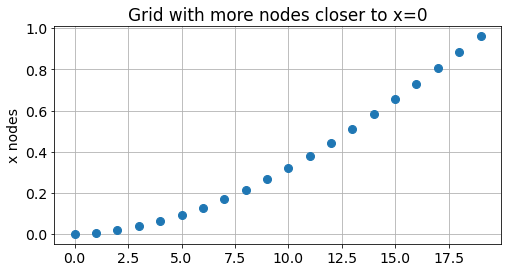

In [219]:
def inv_cheb_nodes(n):
    # This function assumes we're on the interval [0,1].
    doubble_n = 2*n
    cheb_nodes = np.arange( doubble_n, dtype = float)
    cheb_nodes = np.cos( (((2*cheb_nodes)+1)*np.pi) / (2 * doubble_n))# nodes over interval [-1,1]
    cheb_nodes = 0.5*2*cheb_nodes + 0.5*2 # nodes over interval [0,2]
    cheb_nodes = np.sort(cheb_nodes) # flipping to get the correct subinterval
    return cheb_nodes[:n]# only returning nodes over interval [0,1] 

n = 20
nodes = inv_cheb_nodes(n)
plt.title('Grid with more nodes closer to x=0')
plt.plot(nodes, 'o')
plt.ylabel('x nodes')
plt.show()

In [192]:
X_equdistant = np.linspace(0, 1, 20)
X_short = inv_cheb_nodes(20)

U_equidistant = solve_system(X_equdistant, func_4, consts)
U_short = solve_system(X_short, func_4, consts)

l2_equidistant = l2_norm(lambda x: np.interp(x, Xk_fine, U_finegrid) - np.interp(x, X_equdistant, U_equidistant))
l2_short = l2_norm(lambda x: np.interp(x, Xk_fine, U_finegrid) - np.interp(x, X_short, U_short))

print("For equidistant nodes the L2 error is: ", l2_equidistant)
print("For more nodes near x=0 the L2 error is: ", l2_short)

For equidistant nodes the L2 error is:  0.0011118188471699187
For more nodes near x=0 the L2 error is:  0.00039927381149130087


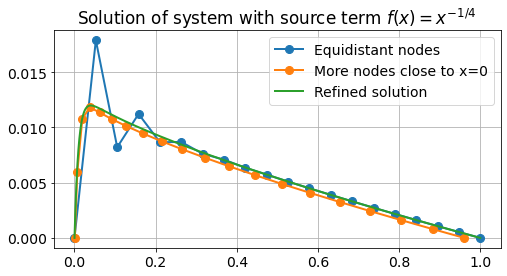

In [222]:
plt.title(r'Solution of system with source term $f(x)=x^{-1/4}$')
plt.plot(X_equdistant, U_equidistant, '-o', label = 'Equidistant nodes')
plt.plot(X_short, U_short, '-o', label = 'More nodes close to x=0')
plt.plot(Xk_fine, U_finegrid, label = 'Refined solution')
plt.legend()
plt.show()